In [1]:
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve


from xgboost import XGBClassifier

import itertools
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import practice_code as pc
import individual_stats as ind

from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
clutch_time = pd.read_csv('CSV Files/clutch_time.csv')

In [3]:
clutch_time = pc.replace_nan(clutch_time)
clutch_time['total_blocks'] = (clutch_time['block'] != '')*1
clutch_time['assist_count'] = (clutch_time['assist'] != '')*1

In [4]:
reg = pd.read_csv('CSV Files/data_for_ids.csv')

In [5]:
ids = ind.add_ids(reg)

# Train_target (2015-2016 season)

In [6]:
train_target= clutch_time[clutch_time['data_set'] == '2015-2016 Regular Season']

In [7]:
stats_train_target = ind.object_to_int(train_target, 'points')
assists = ind.assist_stats(stats_train_target)
blks = ind.blk_stats(stats_train_target)
names = ind.player_names(stats_train_target)
train_target_stats = ind.merge_all(names, blks, assists, stats_train_target)
train_target_stats = ind.get_per_game_stats(train_target_stats)
train_target_stats = ind.merge_ids(train_target_stats, ids)

In [8]:
train_target_stats = ind.add_league_avg(train_target_stats)


# Train data (2004-2015)

In [9]:
train_clutch = clutch_time[clutch_time['data_set'] != '2015-2016 Regular Season']

In [10]:
train_clutch_time = pc.replace_nan(train_clutch)
train_clutch_time['total_blocks'] = (train_clutch_time['block'] != '')*1
train_clutch_time['assist_count'] = (train_clutch_time['assist'] != '')*1

In [11]:
player_stats_clutch = ind.object_to_int(train_clutch_time, 'points')
assists = ind.assist_stats(player_stats_clutch)
blks = ind.blk_stats(player_stats_clutch)
names = ind.player_names(player_stats_clutch)
train_clutch_stats = ind.merge_all(names, blks, assists, player_stats_clutch)
train_clutch_stats = ind.get_per_game_stats(train_clutch_stats)
train_clutch_stats = ind.merge_ids(train_clutch_stats, ids)

In [12]:
train_clutch_stats = ind.add_league_avg(train_clutch_stats)


# Test target (clutch or not in 2016-2017 season)

In [13]:
test_target = pd.read_csv('Test_data/first_test.csv')

In [14]:
test_target = test_target.drop('id', axis =1)
test_target = ind.merge_ids(test_target, ids)
test_target = ind.add_league_avg(test_target)

# X_test data

In [15]:
test_clutch_time = pc.replace_nan(clutch_time)
test_clutch_time['total_blocks'] = (test_clutch_time['block'] != '')*1
test_clutch_time['assist_count'] = (test_clutch_time['assist'] != '')*1

In [16]:
player_stats_test = ind.object_to_int(test_clutch_time, 'points')
assists = ind.assist_stats(player_stats_test)
blks = ind.blk_stats(player_stats_test)
names = ind.player_names(player_stats_test)
test_clutch_stats = ind.merge_all(names, blks, assists, player_stats_test)
test_clutch_stats = ind.get_per_game_stats(test_clutch_stats)
test_clutch_stats = ind.merge_ids(test_clutch_stats, ids)

In [17]:
test_clutch_stats = ind.add_league_avg(test_clutch_stats)

# import csv files for turnovers and ejections

### Keep al the ejections from total game sbecause if they are ejected they cant comebacck

In [18]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [19]:
turnover_data = turnover_data[turnover_data['data_set']!= '2015-2016 Regular Season']

In [20]:
turnover_data['pts_difference'] = turnover_data['away_score'] - turnover_data['home_score']

In [21]:
turnover_data = pc.clutch_moment(turnover_data)

In [22]:
x = turnover_data.groupby('player').count()
turnover_data = x[['event_type']]
turnover_data.reset_index(level=0, inplace=True)
turnover_data = turnover_data.rename(columns={'event_type':'total_turnovers'})

# merge these to train data

In [23]:
train_clutch_stats = pd.merge(train_clutch_stats,turnover_data,on='player', how = 'left')
                              
#ejection_data,on='player', how = 'left')


In [24]:
train_clutch_stats = train_clutch_stats.fillna(0)

In [25]:
train_clutch_stats['TPG'] = round(train_clutch_stats['total_turnovers'] / train_clutch_stats['total_games'],2)

In [27]:
#train_clutch_stats['league_TO_avg'] = round(train_clutch_stats['total_turnovers'].sum() / train_clutch_stats['total_games'].sum(),2)

# get TO and ejection data for train target

In [26]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [27]:
#target_ejection_data = ejection_data[ejection_data['data_set'] == '2015-2016 Regular Season']
target_turnover_data = turnover_data[turnover_data['data_set'] == '2015-2016 Regular Season']

In [28]:
target_turnover_data['pts_difference'] = target_turnover_data['away_score'] - target_turnover_data['home_score']

In [29]:
target_turnover_data = pc.clutch_moment(target_turnover_data)

In [30]:
x = target_turnover_data.groupby('player').count()
target_turnover_data = x[['event_type']]
target_turnover_data.reset_index(level=0, inplace=True)
target_turnover = target_turnover_data.rename(columns={'event_type':'total_turnovers'})

In [31]:
train_target_stats = pd.merge(train_target_stats,target_turnover,on='player', how = 'left')
train_target_stats = train_target_stats.fillna(0)
train_target_stats['TPG'] = round(train_target_stats['total_turnovers'] / train_target_stats['total_games'],2)
#train_target_stats['league_TO_avg'] = round(train_target_stats['total_turnovers'].sum() / train_target_stats['total_games'].sum(),2)
#train_target_stats['clutch_TO'] = train_target_stats['TPG'] < train_target_stats['league_TO_avg']
#target_clutch_stats['clutch_ejections'] = target_clutch_stats['ejections'] < target_clutch_stats['ejections/career']


# Do the same for x_test aka clutch time

In [32]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [33]:
turnover_data['pts_difference'] = turnover_data['away_score'] - turnover_data['home_score']
turnover_data = pc.clutch_moment(turnover_data)

In [34]:
x = turnover_data.groupby('player').count()
turnover_data = x[['event_type']]
turnover_data.reset_index(level=0, inplace=True)
turnover_data = turnover_data.rename(columns={'event_type':'total_turnovers'})

In [35]:
test_clutch_stats = pd.merge(test_clutch_stats,turnover_data,on='player', how = 'left')
test_clutch_stats = test_clutch_stats.fillna(0)
test_clutch_stats['TPG'] = round(test_clutch_stats['total_turnovers'] / test_clutch_stats['total_games'],2)
#test_clutch_stats['league_TO_avg'] = round(test_clutch_stats['total_turnovers'].sum() / test_clutch_stats['total_games'].sum(),2)
#test_clutch_stats['clutch_TO'] = test_clutch_stats['TPG'] < test_clutch_stats['league_TO_avg']


# And for the test target

In [36]:
test_target = pd.read_csv('Every_Season_Data/[2016-2017]-combined-stats.csv')
turnovers = test_target[test_target['event_type'].str.contains('urnover')]
turnovers['pts_difference'] = turnovers['away_score'] - turnovers['home_score']
turnovers = pc.clutch_moment(turnovers)
x = turnovers.groupby('player').count()
turnovers = x[['event_type']]
turnovers.reset_index(level=0, inplace=True)
turnovers = turnovers.rename(columns={'event_type':'total_turnovers'})

In [37]:
test_target = pd.read_csv('Every_Season_Data/[2016-2017]-combined-stats.csv')

In [38]:
test_target =  pc.add_columns(test_target)

In [39]:
col_to_remove = ['a1', 'a2', 'a3','a4','a5','h1','h2','h3','h4','h5', 'play_length', 'entered', 'left', 'possession', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'num', 'away', 'home', 'outof', 'opponent', 'reason', 'elapsed', 'play_id']

In [40]:
test_target = pc.replace_nan(test_target)
test_target = pc.remove_col(test_target, col_to_remove)
test_target = pc.remove_junk_rows(test_target, 'event_type')
regu, poffs = pc.regular_or_playoffs(test_target, 'data_set')

In [41]:
clutch = pc.clutch_moment(regu)
clutch = pc.remove_not_imp_games(clutch, 'game_id')

In [42]:
clutch = ind.object_to_int(clutch, 'points')
ast = ind.assist_stats(clutch)
blk = ind.blk_stats(clutch)
nme = ind.player_names(clutch)
clutch = ind.merge_all(nme, blk, ast, clutch)

In [43]:
test_target = ind.get_per_game_stats(clutch)
test_target = ind.merge_ids(test_target, ids)

In [44]:
test_target = ind.add_league_avg(test_target)


In [45]:
target = pd.merge(test_target,turnovers,on='player', how = 'left')
target = target.fillna(0)
target['TPG'] = round(target['total_turnovers'] / target['total_games'],2)
#target['league_TO_avg'] = round(target['total_turnovers'].sum() / target['total_games'].sum(),2)
#target['ejections'] = test_clutch_stats['ejections'].astype(np.int64)
#target['ejections/career']=round((test_clutch_stats['ejections'].sum() / test_clutch_stats['player'].count()), 2)
#target['clutch_TO'] = target['TPG'] < target['league_TO_avg']
#target['clutch_ejections'] = test_clutch_stats['ejections'] < test_clutch_stats['ejections/career']


In [46]:
train_target_stats = ind.add_scores(train_target_stats)
target = ind.add_scores(target)
train_clutch_stats = ind.add_scores(train_clutch_stats)
test_clutch_stats = ind.add_scores(test_clutch_stats)

In [47]:
train_target_stats = ind.is_clutch(train_target_stats)
target = ind.is_clutch(target)
train_clutch_stats = ind.is_clutch(train_clutch_stats)
test_clutch_stats = ind.is_clutch(test_clutch_stats)

# making sure that i have same players in y_train and x_train

In [48]:
players = train_target_stats[['player']]
train_clutch_stats = train_clutch_stats.merge(players, on='player')


In [49]:
# making sure that i have same players in y_train and x_train
x = train_clutch_stats[['player']]
train_target_stats = train_target_stats.merge(x, on='player')

# gotta get the same players in x_test and y_test

In [50]:
d = target[['player']]
test_clutch_stats = test_clutch_stats.merge(d, on='player')

In [51]:
#gotta get the same players in x_test and y_test
y = test_clutch_stats[['player']]
target = target.merge(y, on='player')

In [52]:
x_train = train_clutch_stats.drop(['total_blocks', '3pt_score','APG', 'total_rebound', '2pt_med/hard', '3pt',  'easy_shot%', 'FT_missed', 'assist_count', '3pt_shots', 'med/hard_fg%', '3pt%', '2pt%', 'Dunk/Layup_attempts', 'total_shots', 'Dunk/Layup', 'FT_made', 'total_games', 'BPG', 'med/hard_attempts', 'FT_score','player_id','player', 'Hard_2Score', 'Easy_2Score', 'clutch_score', '2pt_fg_made', '2fg_attempts','is_clutch', 'league_all_shot_avg',	'league_2pt_avg',	'league_3pt_avg',	'league_hard2pt_avg',	'league_easy2pt_avg',	'league_ft%'], axis = 1)
y_train = train_target_stats['is_clutch']


In [53]:
x_test = test_clutch_stats.drop(['total_blocks', '3pt_score','APG', 'total_rebound', '2pt_med/hard', '3pt',  'easy_shot%', 'FT_missed', 'assist_count', '3pt_shots', 'med/hard_fg%', '3pt%', '2pt%', 'Dunk/Layup_attempts', 'total_shots', 'Dunk/Layup', 'FT_made', 'total_games', 'BPG', 'med/hard_attempts', 'FT_score', 'Hard_2Score', 'Easy_2Score', 'clutch_score', '2pt_fg_made', '2fg_attempts','player_id','player', 'is_clutch', 'league_all_shot_avg',	'league_2pt_avg',	'league_3pt_avg',	'league_hard2pt_avg',	'league_easy2pt_avg',	'league_ft%'], axis = 1)
y_test = target['is_clutch']

In [54]:
#model= GradientBoostingClassifier(learning_rate=0.28, max_depth=3, min_samples_leaf=100, n_estimators=100)
model= GradientBoostingClassifier(learning_rate= 0.01,max_depth= 5,min_samples_leaf= 1,n_estimators= 100)
fit = model.fit(x_train, y_train)
pred= fit.predict(x_test)


In [55]:
accuracy_score(y_test, pred)

0.8692307692307693

In [56]:
precision_score(y_test, pred)

0.42857142857142855

In [57]:
recall_score(y_test, pred)

0.09090909090909091

In [58]:
f1_score(y_test, pred)

0.15000000000000002

In [59]:
importances = model.feature_importances_
importances

array([0.07175749, 0.19001377, 0.168012  , 0.03899681, 0.1272355 ,
       0.10168162, 0.08669612, 0.0910673 , 0.03925876, 0.08528061])

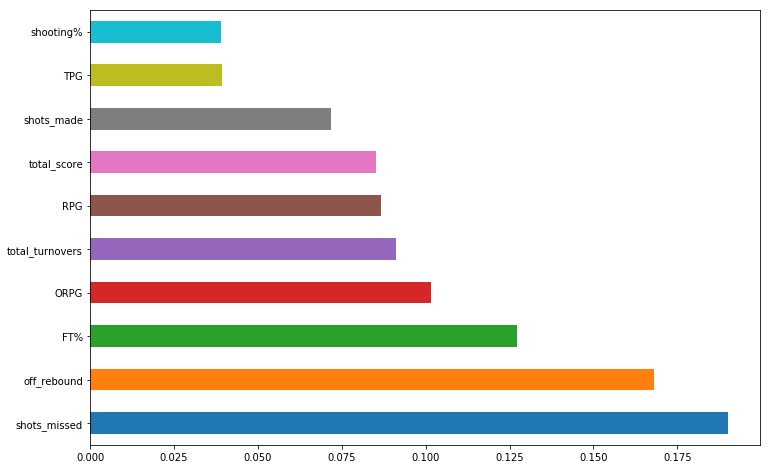

In [60]:
ig, axs = plt.subplots(1,0, figsize=(12,8))
(pd.Series(model.feature_importances_, index=x_test.columns)
   .nlargest(50)
   .plot(kind='barh'))

In [ ]:

'total_turnovers', 'shots_made', 'total_rebound', 'med/hard_attempts', 
'APG', 'Dunk/Layup', 'FT made', 'clutch_score', '2pt%', 'assist_count',
'total_blocks', 'ORPG', 'med/hard_fg%', 'total_score', 'off_rebound', 
'FT_score', 'FT%', 'Hard_2Score', 



In [277]:
parameters = {'learning_rate': [.3, .15, .2], 'n_estimators': [10, 30, 15], 'max_depth': [1,2], 
                                                               'min_samples_leaf': [1,3,5]}

In [278]:
gbc = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, scoring='recall')
gbc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.3, 0.15, 0.2], 'n_estimators': [10, 30, 15], 'max_depth': [1, 2], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [279]:
gbc.best_params_

{'learning_rate': 0.3,
 'max_depth': 2,
 'min_samples_leaf': 5,
 'n_estimators': 30}

In [280]:
gbc.best_score_

0.16666666666666666

In [ ]:
accuracy: .9087,  
    
    best_params: {'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [ ]:
recall: .2
    {'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 10}
    

In [256]:
params={'max_depth': [1,3,5],'learning_rate': [0.1,0.2, .01], 'n_estimators': [10,20,50,100], 'min_child_weight':[1,2,5]}



In [257]:
XGB = GridSearchCV(XGBClassifier(), params, cv= 10, scoring='recall')
XGB.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3], 'learning_rate': [0.18, 0.2, 0.25], 'n_estimators': [10, 20, 15], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [258]:
XGB.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 10}

In [255]:
XGB.best_score_

0.902027027027027

In [ ]:
acc: .902
Best Params:
    {'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 10}

In [281]:
model = XGBClassifier(learning_rate=.2, max_depth=3, n_estimators=10, min_child_weight=2 )
#model = XGBClassifier()
model.fit(x_train, y_train)
print(model)
y_pred=model.predict(x_test)
print("recall: %.2f%%" % recall_score(y_test, y_pred))
print("f1: %.2f%%" % f1_score(y_test, pred))
print("Accuracy: %.3f%%" % accuracy_score(y_test, y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
recall: 0.03%
f1: 0.15%
Accuracy: 0.862%


In [282]:
precision_score(y_test, y_pred)

0.2

In [229]:
x = model.feature_importances_

In [230]:
x

array([0.2       , 0.09462366, 0.1032258 , 0.12903225, 0.15268818,
       0.14408602, 0.08602151, 0.09032258], dtype=float32)

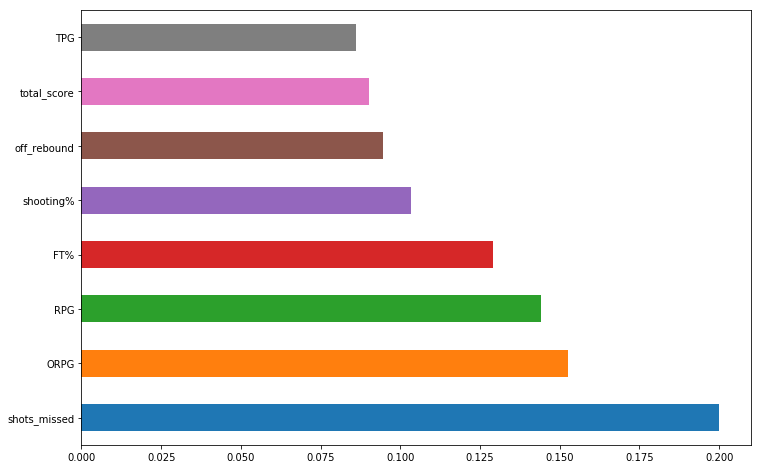

In [231]:
ig, axs = plt.subplots(1,0, figsize=(12,8))
(pd.Series(model.feature_importances_, index=x_test.columns)
   .nlargest(30)
   .plot(kind='barh'))

# Baseline model 
## Looks at all the shots and if your shooting% is above league avg yu are clutch 

In [57]:
target['clutch_all_shots'] = ((target['shooting%'] > target['league_all_shot_avg']) & (target['total_shots']>20))*1

test_clutch_stats['clutch_all_shots'] = ((test_clutch_stats['shooting%'] > test_clutch_stats['league_all_shot_avg']) & (test_clutch_stats['total_shots']>30))*1

train_clutch_stats['clutch_all_shots'] = ((train_clutch_stats['shooting%'] > train_clutch_stats['league_all_shot_avg']) & (train_clutch_stats['total_shots']>30))*1    
    
train_target_stats['clutch_all_shots'] = ((train_target_stats['shooting%'] > train_target_stats['league_all_shot_avg']) & (train_target_stats['total_shots']>20))*1

    
    

In [65]:
x_train = train_clutch_stats.drop(['player', 'player_id'],axis = 1)
y_train = train_target_stats['clutch_all_shots']
y_test = target['clutch_all_shots']
x_test = test_clutch_stats.drop(['player', 'player_id'],axis = 1)

In [66]:
model= GradientBoostingClassifier()
fit = model.fit(x_train, y_train)
pred= fit.predict(x_test)

In [67]:
recall_score(y_test, pred)

0.058823529411764705

In [68]:
f1_score(y_test, pred)

0.08888888888888888

In [71]:
accuracy_score(y_test, pred)

0.8423076923076923

In [72]:
precision_score(y_test, pred)

0.18181818181818182

In [ ]:
# x = ejects.groupby('player').count()
# ejects = x[['event_type']]
# ejects.reset_index(level=0, inplace=True)
# ejects = ejects.rename(columns={'event_type':'ejections'})

In [ ]:
# x = ejection_data.groupby('player').count()
# ejection_data = x[['event_type']]
# ejection_data.reset_index(level=0, inplace=True)
# ejection_data = ejection_data.rename(columns={'event_type':'ejections'})

In [ ]:
# d = []
# e = 0
# for value in x['total_shots']:
#     if value > 20:
#         y = 
#         d.append(value)
#     else:
#         d.append(e)
# x[''] = d



# d = []
# e = 0
# for value in x['3pt_shots']:
#     if value >= 10:
#         d.append(value)
#     else:
#         d.append(e)
# x['3pt_shots'] = d

In [ ]:
#ejection_data = pd.read_csv('CSV Files/reg_ejects.csv')
#ejection_data = ejection_data[ejection_data['data_set']!= '2015-2016 Regular Season']

In [ ]:
# train_clutch_stats['ejections'] = train_clutch_stats['ejections'].astype(np.int64)
# train_clutch_stats['ejections/career']=round((train_clutch_stats['ejections'].sum() / train_clutch_stats['player'].count()), 2)

In [ ]:
# new_id = []
# v = test_target['id'].max()
# for value in test_target['id']:
#     if value == 0:
#         v +=1
#         new_id.append(v)
#     else:
#         new_id.append(value)
# test_target['id'] = new_id

# Final test data

In [61]:
final_test = pd.read_csv('Every_Season_Data/[2017-2018]-combined-stats.csv', error_bad_lines=False)

b'Skipping line 34257: expected 44 fields, saw 46\nSkipping line 34258: expected 44 fields, saw 46\nSkipping line 34259: expected 44 fields, saw 46\nSkipping line 34260: expected 44 fields, saw 46\nSkipping line 34261: expected 44 fields, saw 46\nSkipping line 34262: expected 44 fields, saw 46\nSkipping line 34263: expected 44 fields, saw 46\nSkipping line 34264: expected 44 fields, saw 46\nSkipping line 34265: expected 44 fields, saw 46\nSkipping line 34266: expected 44 fields, saw 46\nSkipping line 34267: expected 44 fields, saw 46\nSkipping line 34268: expected 44 fields, saw 46\nSkipping line 34269: expected 44 fields, saw 46\nSkipping line 34270: expected 44 fields, saw 46\nSkipping line 34271: expected 44 fields, saw 46\nSkipping line 34272: expected 44 fields, saw 46\nSkipping line 34273: expected 44 fields, saw 46\nSkipping line 34274: expected 44 fields, saw 46\nSkipping line 34275: expected 44 fields, saw 46\nSkipping line 34276: expected 44 fields, saw 46\nSkipping line 3427

In [62]:
final_test = pc.add_columns(final_test)
final_test = pc.remove_junk_rows(final_test, 'event_type')
col_to_remove = ['a1', 'a2', 'a3','a4','a5','h1','h2','h3','h4','h5', 'play_length', 'entered', 'left', 'possession', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'num', 'away', 'home', 'outof', 'opponent', 'reason', 'elapsed', 'play_id']
final_test = pc.remove_col(final_test, col_to_remove)
final_test = pc.replace_nan(final_test)
final_regular_season, final_playoffs = pc.regular_or_playoffs(final_test, 'data_set')
final_clutch = pc.clutch_moment(final_regular_season)
final_clutch = pc.remove_not_imp_games(final_clutch, 'game_id')

In [63]:
final_clutch['total_blocks'] = (final_clutch['block'] != '')*1
final_clutch['assist_count'] = (final_clutch['assist'] != '')*1

In [9]:
#final_clutch['game_id'] = final_clutch['game_id'].astype('category')

In [10]:
#final_regular_season.date= pd.to_datetime(final_regular_season.date).dt.strftime('%d-%b-%y')

In [64]:
test_stats_clutch = ind.change_objects(final_clutch)

In [65]:
assists = ind.assist_stats(test_stats_clutch)
blks = ind.blk_stats(test_stats_clutch)
names = ind.player_names(test_stats_clutch)
names = ind.player_names(test_stats_clutch)
full_test_clutch_stats = ind.merge_all(names, blks, assists, test_stats_clutch)
full_test_clutch_stats = ind.get_per_game_stats(full_test_clutch_stats)
full_test_clutch_stats = ind.merge_ids(full_test_clutch_stats, ids)

In [66]:
full_test_clutch_stats = ind.add_league_avg(full_test_clutch_stats)

In [67]:
final_tos = pd.read_csv('Every_Season_Data/[2017-2018]-combined-stats.csv', error_bad_lines=False)
final_turnovers = final_tos[final_tos['event_type'].str.contains('urnover')]
final_turnovers['pts_difference'] = final_turnovers['away_score'] - final_turnovers['home_score']
final_turnovers = pc.clutch_moment(final_turnovers)
x = final_turnovers.groupby('player').count()
final_turnovers = x[['event_type']]
final_turnovers.reset_index(level=0, inplace=True)
final_turnovers = final_turnovers.rename(columns={'event_type':'total_turnovers'})

b'Skipping line 34257: expected 44 fields, saw 46\nSkipping line 34258: expected 44 fields, saw 46\nSkipping line 34259: expected 44 fields, saw 46\nSkipping line 34260: expected 44 fields, saw 46\nSkipping line 34261: expected 44 fields, saw 46\nSkipping line 34262: expected 44 fields, saw 46\nSkipping line 34263: expected 44 fields, saw 46\nSkipping line 34264: expected 44 fields, saw 46\nSkipping line 34265: expected 44 fields, saw 46\nSkipping line 34266: expected 44 fields, saw 46\nSkipping line 34267: expected 44 fields, saw 46\nSkipping line 34268: expected 44 fields, saw 46\nSkipping line 34269: expected 44 fields, saw 46\nSkipping line 34270: expected 44 fields, saw 46\nSkipping line 34271: expected 44 fields, saw 46\nSkipping line 34272: expected 44 fields, saw 46\nSkipping line 34273: expected 44 fields, saw 46\nSkipping line 34274: expected 44 fields, saw 46\nSkipping line 34275: expected 44 fields, saw 46\nSkipping line 34276: expected 44 fields, saw 46\nSkipping line 3427

In [68]:
full_test_clutch_stats = pd.merge(full_test_clutch_stats, final_turnovers, on='player', how = 'left')
full_test_clutch_stats = full_test_clutch_stats.fillna(0)
full_test_clutch_stats['TPG'] = round(full_test_clutch_stats['total_turnovers'] / full_test_clutch_stats['total_games'],2)

In [69]:
full_test_clutch_stats = ind.add_scores(full_test_clutch_stats)

full_test_clutch_stats = ind.is_clutch(full_test_clutch_stats)

# Final X_train

In [70]:
final_train = ind.object_to_int(clutch_time, 'points')
assists = ind.assist_stats(final_train)
blks = ind.blk_stats(final_train)
names = ind.player_names(final_train)
final_train_stats = ind.merge_all(names, blks, assists, final_train)
final_train_stats = ind.get_per_game_stats(final_train_stats)
final_train_stats = ind.merge_ids(final_train_stats, ids)

In [71]:
final_train_tos = pd.read_csv('CSV Files/clutch_time.csv', error_bad_lines=False)
final_train_turnovers = final_train_tos[final_train_tos['event_type'].str.contains('urnover')]
final_train_turnovers['pts_difference'] = final_train_turnovers['away_score'] - final_train_turnovers['home_score']
final_train_turnovers = pc.clutch_moment(final_train_turnovers)
x = final_train_turnovers.groupby('player').count()
final_train_turnovers = x[['event_type']]
final_train_turnovers.reset_index(level=0, inplace=True)
final_train_turnovers = final_train_turnovers.rename(columns={'event_type':'total_turnovers'})

In [72]:
final_train_stats = ind.add_league_avg(final_train_stats)
final_train_stats = pd.merge(final_train_stats,turnovers,on='player', how = 'left')
final_train_stats = final_train_stats.fillna(0)
final_train_stats['TPG'] = round(final_train_stats['total_turnovers'] / final_train_stats['total_games'],2)

In [73]:
final_train_stats = ind.add_scores(final_train_stats)
final_train_stats = ind.is_clutch(final_train_stats)

# Final y_train

In [74]:
y_train = target['is_clutch']

# Final X-test

In [75]:
x_test = pd.read_csv('CSV Files/final_x_test.csv')

In [76]:
x_test = pc.replace_nan(x_test)

In [77]:
x_test['total_blocks'] = (x_test['block'] != '')*1
x_test['assist_count'] = (x_test['assist'] != '')*1

In [78]:
x_test['points'].replace(to_replace='', value= -1, inplace=True)

In [79]:
assists = ind.assist_stats(x_test)
blks = ind.blk_stats(x_test)
names = ind.player_names(x_test)
x_test_clutch_stats = ind.merge_all(names, blks, assists, x_test)
x_test_clutch_stats = ind.get_per_game_stats(x_test_clutch_stats)
x_test_clutch_stats = ind.merge_ids(x_test_clutch_stats, ids)

In [80]:
x_test_clutch_stats = ind.add_league_avg(x_test_clutch_stats)

In [81]:
to_data = pd.read_csv('CSV Files/final_test_tos.csv')

In [82]:
to_data['pts_difference'] = to_data['away_score'] - to_data['home_score']
to_data = pc.clutch_moment(to_data)
x = to_data.groupby('player').count()
final_X_turnovers = x[['event_type']]
final_X_turnovers.reset_index(level=0, inplace=True)
final_X_turnovers = final_X_turnovers.rename(columns={'event_type':'total_turnovers'})

In [83]:
x_test_clutch_stats = pd.merge(x_test_clutch_stats, final_X_turnovers, on='player', how = 'left')
x_test_clutch_stats = x_test_clutch_stats.fillna(0)
x_test_clutch_stats['TPG'] = round(x_test_clutch_stats['total_turnovers'] / x_test_clutch_stats['total_games'],2)

In [84]:
x_test_clutch_stats = ind.add_scores(x_test_clutch_stats)

x_test_clutch_stats = ind.is_clutch(x_test_clutch_stats)

# Final y_test

In [85]:
y_test = full_test_clutch_stats['is_clutch']

# Final test

In [86]:
players = x_test_clutch_stats[['player']]
full_test_clutch_stats = full_test_clutch_stats.merge(players, on='player')

x = full_test_clutch_stats[['player']]
x_test_clutch_stats = x_test_clutch_stats.merge(x, on='player')

In [87]:
d = target[['player']]
final_train_stats = final_train_stats.merge(d, on='player')

y = final_train_stats[['player']]
target = target.merge(y, on='player')

In [88]:
x_test = x_test_clutch_stats.drop(['total_blocks', '3pt_score','APG', 'total_rebound', '2pt_med/hard', '3pt',  'easy_shot%', 'FT_missed', 'assist_count', '3pt_shots', 'med/hard_fg%', '3pt%', '2pt%', 'Dunk/Layup_attempts', 'total_shots', 'Dunk/Layup', 'FT_made', 'total_games', 'BPG', 'med/hard_attempts', 'FT_score','player_id','player', 'Hard_2Score', 'Easy_2Score', 'clutch_score', '2pt_fg_made', '2fg_attempts','is_clutch', 'league_all_shot_avg',	'league_2pt_avg',	'league_3pt_avg',	'league_hard2pt_avg',	'league_easy2pt_avg',	'league_ft%'], axis = 1)
x_train = final_train_stats.drop(['total_blocks', '3pt_score','APG', 'total_rebound', '2pt_med/hard', '3pt',  'easy_shot%', 'FT_missed', 'assist_count', '3pt_shots', 'med/hard_fg%', '3pt%', '2pt%', 'Dunk/Layup_attempts', 'total_shots', 'Dunk/Layup', 'FT_made', 'total_games', 'BPG', 'med/hard_attempts', 'FT_score','player_id','player', 'Hard_2Score', 'Easy_2Score', 'clutch_score', '2pt_fg_made', '2fg_attempts','is_clutch', 'league_all_shot_avg',	'league_2pt_avg',	'league_3pt_avg',	'league_hard2pt_avg',	'league_easy2pt_avg',	'league_ft%'], axis = 1)

In [89]:
y_test = full_test_clutch_stats['is_clutch']
y_train = target['is_clutch']

In [90]:
model= GradientBoostingClassifier(learning_rate= 0.01,max_depth= 5,min_samples_leaf= 1,n_estimators= 100)
fit = model.fit(x_train, y_train)
pred= fit.predict(x_test)

In [91]:
accuracy_score(y_test, pred)

0.8730769230769231

In [92]:
recall_score(y_test, pred)

0.10526315789473684

In [93]:
f1_score(y_test, pred)

0.10810810810810811

In [94]:
precision_score(y_test, pred)

0.1111111111111111

In [334]:
model.feature_importances_

array([0.10796367, 0.07701012, 0.08964119, 0.07334394, 0.04192753,
       0.08646945, 0.08103295, 0.14358062, 0.09943053, 0.19959999])

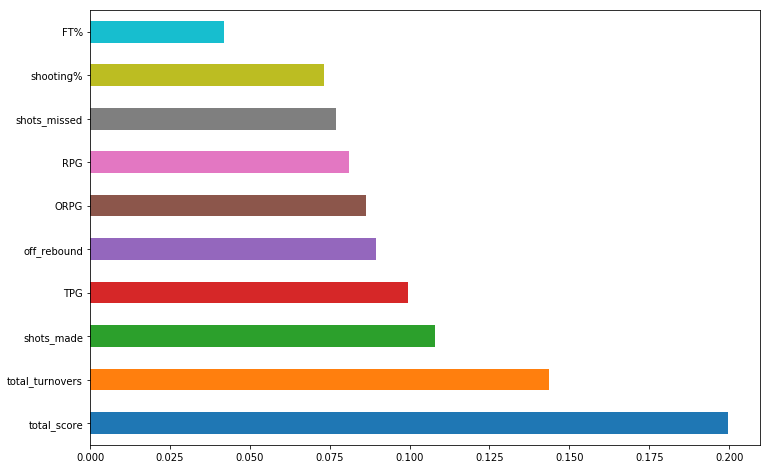

In [335]:
ig, axs = plt.subplots(1,0, figsize=(12,8))
(pd.Series(model.feature_importances_, index=x_test.columns)
   .nlargest(50)
   .plot(kind='barh'))

In [311]:
full_test_clutch_stats.is_clutch.value_counts()

0    241
1     19
Name: is_clutch, dtype: int64

In [312]:
241/260

0.926923076923077

In [ ]:
'total_turnovers', 'shots_made', 'total_rebound', 'med/hard_attempts', 'APG', 'Dunk/Layup', 'FT made', 'clutch_score', '2pt%', 'assist_count', 'total_blocks', 'ORPG', 'med/hard_fg%', 'total_score', 'off_rebound', 'FT_score', 'FT%', 'Hard_2Score', 'TPG'
